In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

path = './additional/sample_1.JPG'


cols = ['Nu_no', 'R', 'G', 'B', 'height', 'width']
df = pd.DataFrame(columns = cols)
    
basename_without_ext = os.path.splitext(os.path.basename(path))[0]

print(basename_without_ext)

sample_1


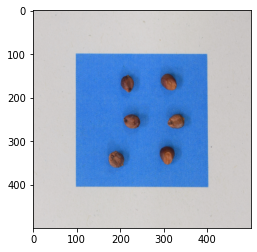

In [2]:
# Detect markers
aruco = cv2.aruco
p_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
corners, ids, rejectedImgPoints = aruco.detectMarkers(img, p_dict) 

m = np.empty((4,2))
corners2 = [np.empty((1,4,2))]*4
for i,c in zip(ids.ravel(), corners):
    corners2[i] = c.copy()
m[0] = corners2[0][0][2]
m[1] = corners2[1][0][3]
m[2] = corners2[2][0][0]
m[3] = corners2[3][0][1]

width, height = (500,500)

marker_coordinates = np.float32(m)
true_coordinates   = np.float32([[0,0],[width,0],[width,height],[0,height]])
trans_mat = cv2.getPerspectiveTransform(marker_coordinates,true_coordinates)
img_trans = cv2.warpPerspective(img,trans_mat,(width, height))

plt.imshow(img_trans)

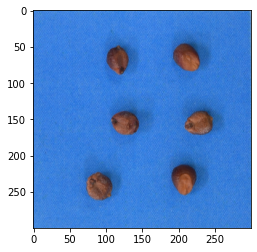

In [3]:

h, w = img_trans.shape[:2]

#余白をトリミング
h1, h2 = int(h * 0.2), int(h * 0.8)
w1, w2 = int(w * 0.2), int(w * 0.8)
original_img = img_trans[h1: h2, w1: w2]

plt.imshow(original_img)


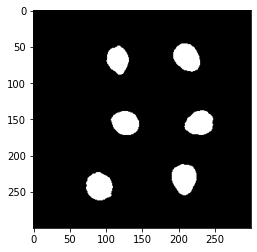

In [5]:
# Binalization
gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2LAB)
gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)

thresh, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV +cv2.THRESH_OTSU)

plt.imshow(bin_img, cmap = 'gray')


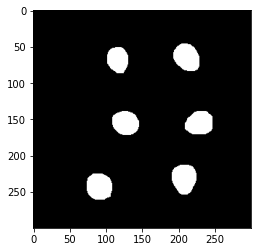

In [6]:
# Opening and closing
kernel_1 = np.ones((5,5), np.uint8)
kernel_2 = np.ones((1,1), np.uint8)
opening = cv2.morphologyEx(bin_img,cv2.MORPH_OPEN,kernel_1,iterations = 2)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_2, iterations = 2)

plt.imshow(closing, cmap = 'gray')


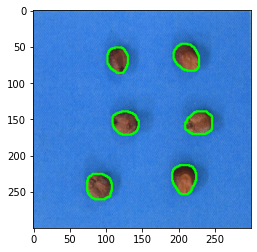

In [7]:
# Draw contours
contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = list(filter(lambda x: cv2.contourArea(x) > 100, contours))
img_cont = cv2.drawContours(original_img, contours, -1, color=(0, 255, 0), thickness= 2) 

plt.imshow(img_cont)


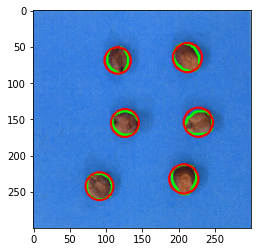

In [8]:

# Draw circumscribed circles

exc_diameter = []
center_pos = []

for i in range(len(contours)):
    cnt = contours[i]
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    exc_center = (int(x),int(y))
    center_pos.append(exc_center)
    exc_radius = int(radius)
    exc_diameter.append(exc_radius*2)
    exc_img = cv2.circle(original_img, exc_center, exc_radius, (255, 0, 0), 2)
    plt.imshow(exc_img)

exc_diameter_mean = np.mean(exc_diameter)


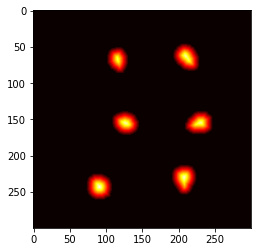

In [10]:

# Make distance map
dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)

plt.imshow(dist_transform, cmap = 'hot')


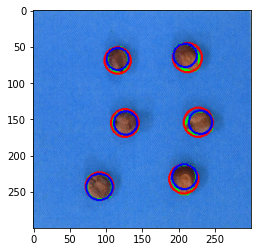

In [11]:

# Draw inscribed circles

inc_diameter = []

h, w = original_img.shape[:2]
mask_bg = np.zeros((h, w), dtype=np.uint8)

for i in range(len(contours)):
    mb = mask_bg.copy()
    dt = dist_transform.copy()
    mask_img = cv2.circle(mb, center_pos[i], int(exc_diameter[i]/2), color = 255, thickness = -1)
    dt[mask_img == 0] = 0
    cen_y, cen_x = np.unravel_index(np.argmax(dt), dt.shape)
    inc_center = (cen_x, cen_y)
    inc_radius = round(dt.max())
    inc_diameter.append(inc_radius*2)
    inc_img = cv2.circle(original_img, inc_center, inc_radius, (0,0,255), 2)
    plt.imshow(inc_img)

inc_diameter_mean = np.mean(inc_diameter)

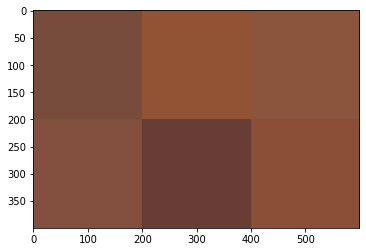

In [12]:
# Get RGB values

rgb = []

for i in range(len(contours)):
    img = original_img.copy()
    mb = mask_bg.copy()
    mask_img = cv2.circle(mb, center_pos[i], int(inc_diameter[i]/2*0.5), color = 255, thickness = -1)
    img[mask_img == 0] = 0 
    for j in range(3):
        r = img[:, :, j]
        r = r[r != 0]
        rgb.append(np.mean(r))

rgb = np.asarray(rgb).reshape(2,3,3).astype('uint8')
rgb_img = cv2.resize(rgb, (600,400), interpolation = cv2.INTER_NEAREST)

plt.imshow(rgb_img)


In [14]:


#plt.imsave('/Users/shumpei/Desktop/種子形質_GWAS/test/color_img/{}_color_img.JPG'.format(basename_without_ext), rgb_img)

rgb = rgb.reshape(6,3)
r_mean = np.mean(rgb[:, 0])
g_mean = np.mean(rgb[:, 1])
b_mean = np.mean(rgb[:, 2])
rgb_mean = np.array([r_mean, g_mean, b_mean])

a = pd.Series([basename_without_ext, round(rgb_mean[0]), round(rgb_mean[1]), round(rgb_mean[2]), 
            round(exc_diameter_mean, 2), round(inc_diameter_mean, 2)], 
            index = df.columns) 
df = df.append(a, ignore_index = True)
    
df

,Nu_no,R,G,B,height,width
0,sample_1,130,77,57,38.67,32.67
